### Test the dataset maker and train a model using a FastAI learner
- starts by building an opensoundscape AudioFileDataset. This is a dataset of file paths and split times, paired with presence/absence labels. By default the AudioFileDataset exposes an AudioSample object when indexed into. The `data` and `labels` properties contain the tensors.
- Uses opensoundscape collate function with fastai dataloaders to collate batches of tensor data and labels. 
- The resulting dataloaders object is passed to a FastAI learner for training. 
- Currently a resnet18 model is used, but this can be swapped out for different pretrainied architectures to leverage transfer learning from a model which was previously trained on spectrograms of birdcalls rather than on images from ImageNet.


In [21]:
# imports
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import torch
import timm
import random


# load the raw dataframe


In [22]:
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


### Take a sample of the recordings
Training loop is slow with all the data - use a sample to speed things up if necessary. 
Samples taken at the recording level

In [23]:
def take_sample(df, sample_fraction=0.1):
    unique_recordings = list(set(df.recording_id))
    sample_size = round(sample_fraction * len(unique_recordings))
    sample_recordings = random.sample(unique_recordings, sample_size)
    df_sample = df[df.recording_id.isin(sample_recordings)]
    print(f"sampled {len(sample_recordings)} recordings from the original {len(unique_recordings)} ")
    return df_sample

df_train_sample = take_sample(df_train, sample_fraction=0.1)


sampled 5442 recordings from the original 54416 


# Turn dataframe into an AudioFileDataset 


10 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    22364
1SPM     7820
None     4109
Name: count, dtype: int64
total recordings = 34293

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                   194.0          1453.0
1SPT                   266.0          3902.0
NaN                     90.0           312.0
total target clips =  550
total absence clips =  5667
total available human labelled target tags = 437
undefined 28076

--------------------------------------------------
after filtering undefined clips
recordings per task method = 
 task_method
1SPT    4168
1SPM    1647
None     402
Name: count, dtype: int64
total recordings = 6217

Tags generated from each tagging method:
             target_presence  target_absence
task_method   

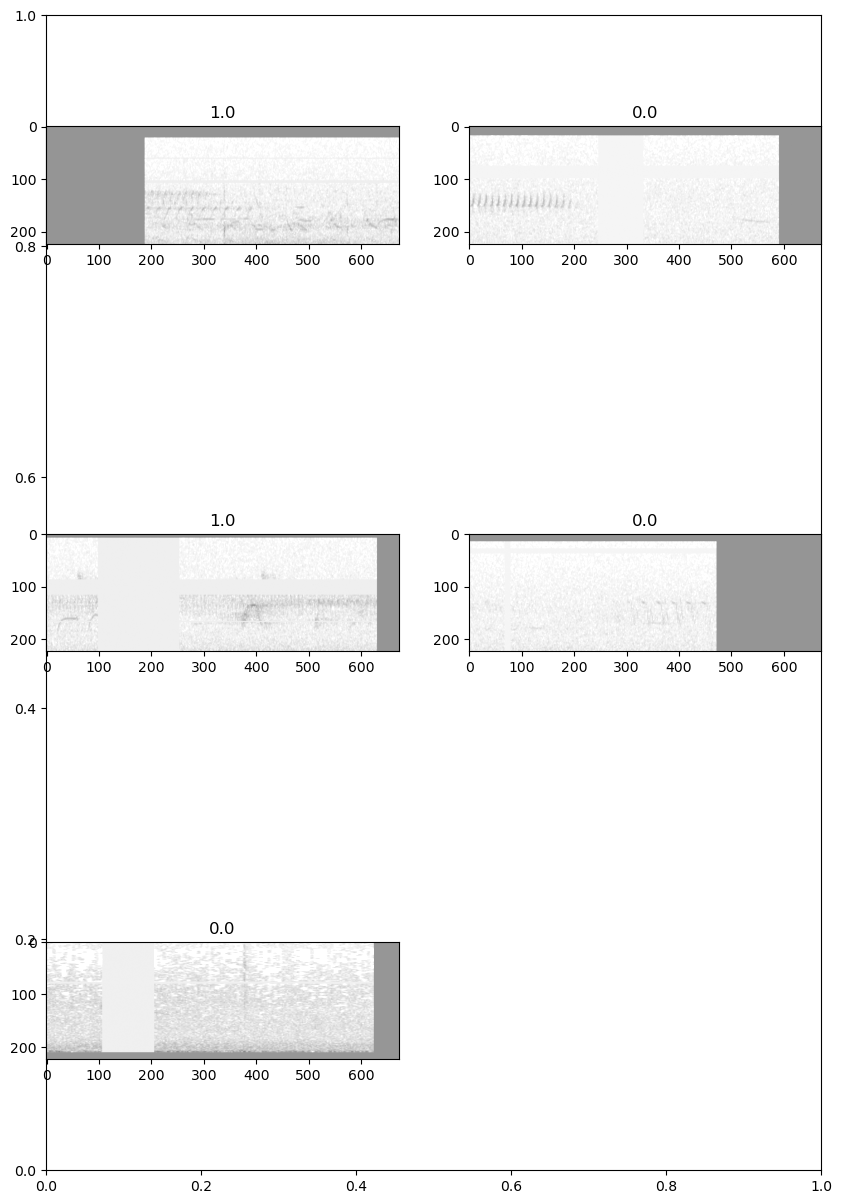

In [24]:
target_species = "OSFL"
train_dataset, valid_dataset, train_locations, valid_locations = src.data.build.dataset_from_df(df_train_sample, target_species=target_species, download_n=0, one_class=False)

# Investigate distribution of tags extracted per task method

When a sample is taken, the number of recordings from each task method varies. The number of tags will vary too, since some recordings contain more tags than others.

### counts before sampling

```
--------------------------------------------------
before filtering undefined clips
total available human labelled target tags = 4204
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
undefined 266459

--------------------------------------------------
after filtering undefined clips
total available human labelled target tags = 4204
recordings per task method = 
 task_method
1SPT    41013
1SPM    15245
None     4024
Name: count, dtype: int64
total recordings = 60282

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
undefined 0
```

The recordings with tagging method `no restrictions` make up only 15% of the total recordings, and they account for 13% of the total target clips. This is fewer than I had expected given that the no restrictions method allows for multiple tags of the same individual in a single task.

The tagging methods `1 species per task` and `1 species per minute` also generate more clips than there are in the original database. This is because the moving window approach with overlap will sometimes be able to capture the same birdcall twice in adjacent windows.

## What locations are the recordings from?

In [25]:
target_df = df_train_sample.loc[df_train_sample.species_code == target_species].copy()
target_df['is_valid'] = target_df.location_id.isin(valid_locations)

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:78: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab20", len(all_features))


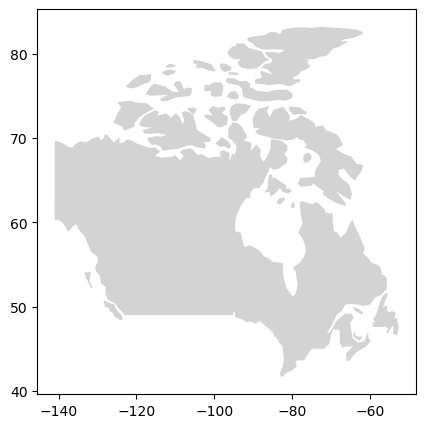

In [26]:
plot_locations(target_df, feature='is_valid')

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:78: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("tab20", len(all_features))


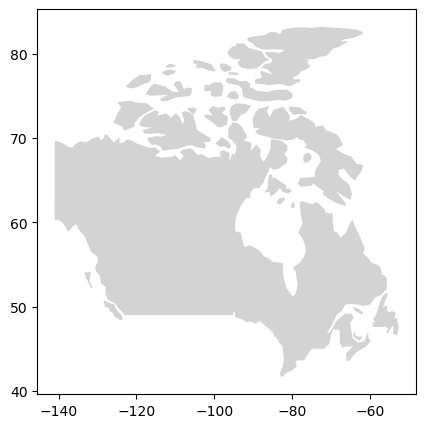

In [27]:
plot_locations(target_df, feature='file_type')

## Resample the dataframes in the AudioFileDataset to get fewer no-call samples
Training set is huge, and training is very slow. If we took a sample, then we'd reduce the number of positive labels in the dataset, which is something we might want to avoid, especially for rarer species or under represented classes. Since there's an abundance of the absent class, undersampling this class might be a better approach. 

If we do just undersample the absent class, and if most of these samples are absent of any bird calls (target or non-target species), then there's a possibility the recognizer ends up being a bird / no bird recognizer and doesn't learn species specific features. So we might also arrange the presence of a certanin proportion of non-target bird vocalizations in the training dataset. 

In [28]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([ 426., 4818.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([124., 849.])))

### Keep a record of the undersampling ratio for use in the loss function during training
If we downsample the abundant class, then it can be upweighted durning training. The downsampled class can be weighted so that loss function sees it as w times more relevant than the reported weight after the activation function. This enables us to keep the model outputs as true probabilities. 

Note that there's some difference in the ratios of classes present in the training set compared with in nature, because of the way the dataset is constructed. These come from:
- the selection of only the first individual tagged within a sample interval during tagging on WildTrax.
- the decision to only use audio from beofre the first tag of a species when building the absence class. 
- the possibility of one vocalization creating multiple tags in the dataset.


In [29]:
target_count, absence_count = train_dataset.class_counts()[1]
absence_upweight = absence_count / target_count
absence_upweight

11.309859154929578

### Downsample the absent class

In [30]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([426., 426.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([124., 124.])))

In [31]:
# optionally remove the redundant second label
def drop_absent_class(ds: opso.AudioFileDataset):
    ds.label_df.drop(columns='target_absence', inplace=True)
# drop_absent_class(train_dataset)
# drop_absent_class(valid_dataset)

### Check that the Dataset looks right

In [32]:
print("training set class counts")
print(train_dataset.label_df.target_presence.value_counts())
print(train_dataset.label_df.target_absence.value_counts())
print("\nvalidation set class counts")
print(valid_dataset.label_df.target_presence.value_counts())
print(valid_dataset.label_df.target_absence.value_counts())

training set class counts
target_presence
1.0    426
0.0    426
Name: count, dtype: int64
target_absence
0.0    426
1.0    426
Name: count, dtype: int64

validation set class counts
target_presence
1.0    124
0.0    124
Name: count, dtype: int64
target_absence
0.0    124
1.0    124
Name: count, dtype: int64


In [33]:
l = len(train_dataset)
[train_dataset[i].labels for i in [1, 2, l-1, l-2]]

[target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4399.mp3, 81.0, 84.0), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4399.mp3, 82.5, 85.5), dtype: float64,
 target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-291747.mp3, 88.5, 91.5), dtype: float64,
 target_presence    0.0
 target_absence     1.0
 Name: (../../data/raw/recordings/OSFL/recording-297001.mp3, 30.0, 33.0), dtype: float64]

There are equal numbers of classes, and there are 2 classes per dataset. After the OpenSoundScape resample method, the dataset ends up sorted by class, so we need to make sure to shuffle it again when loading batches of training data. 

# Look at typical spectrograms from the dataset

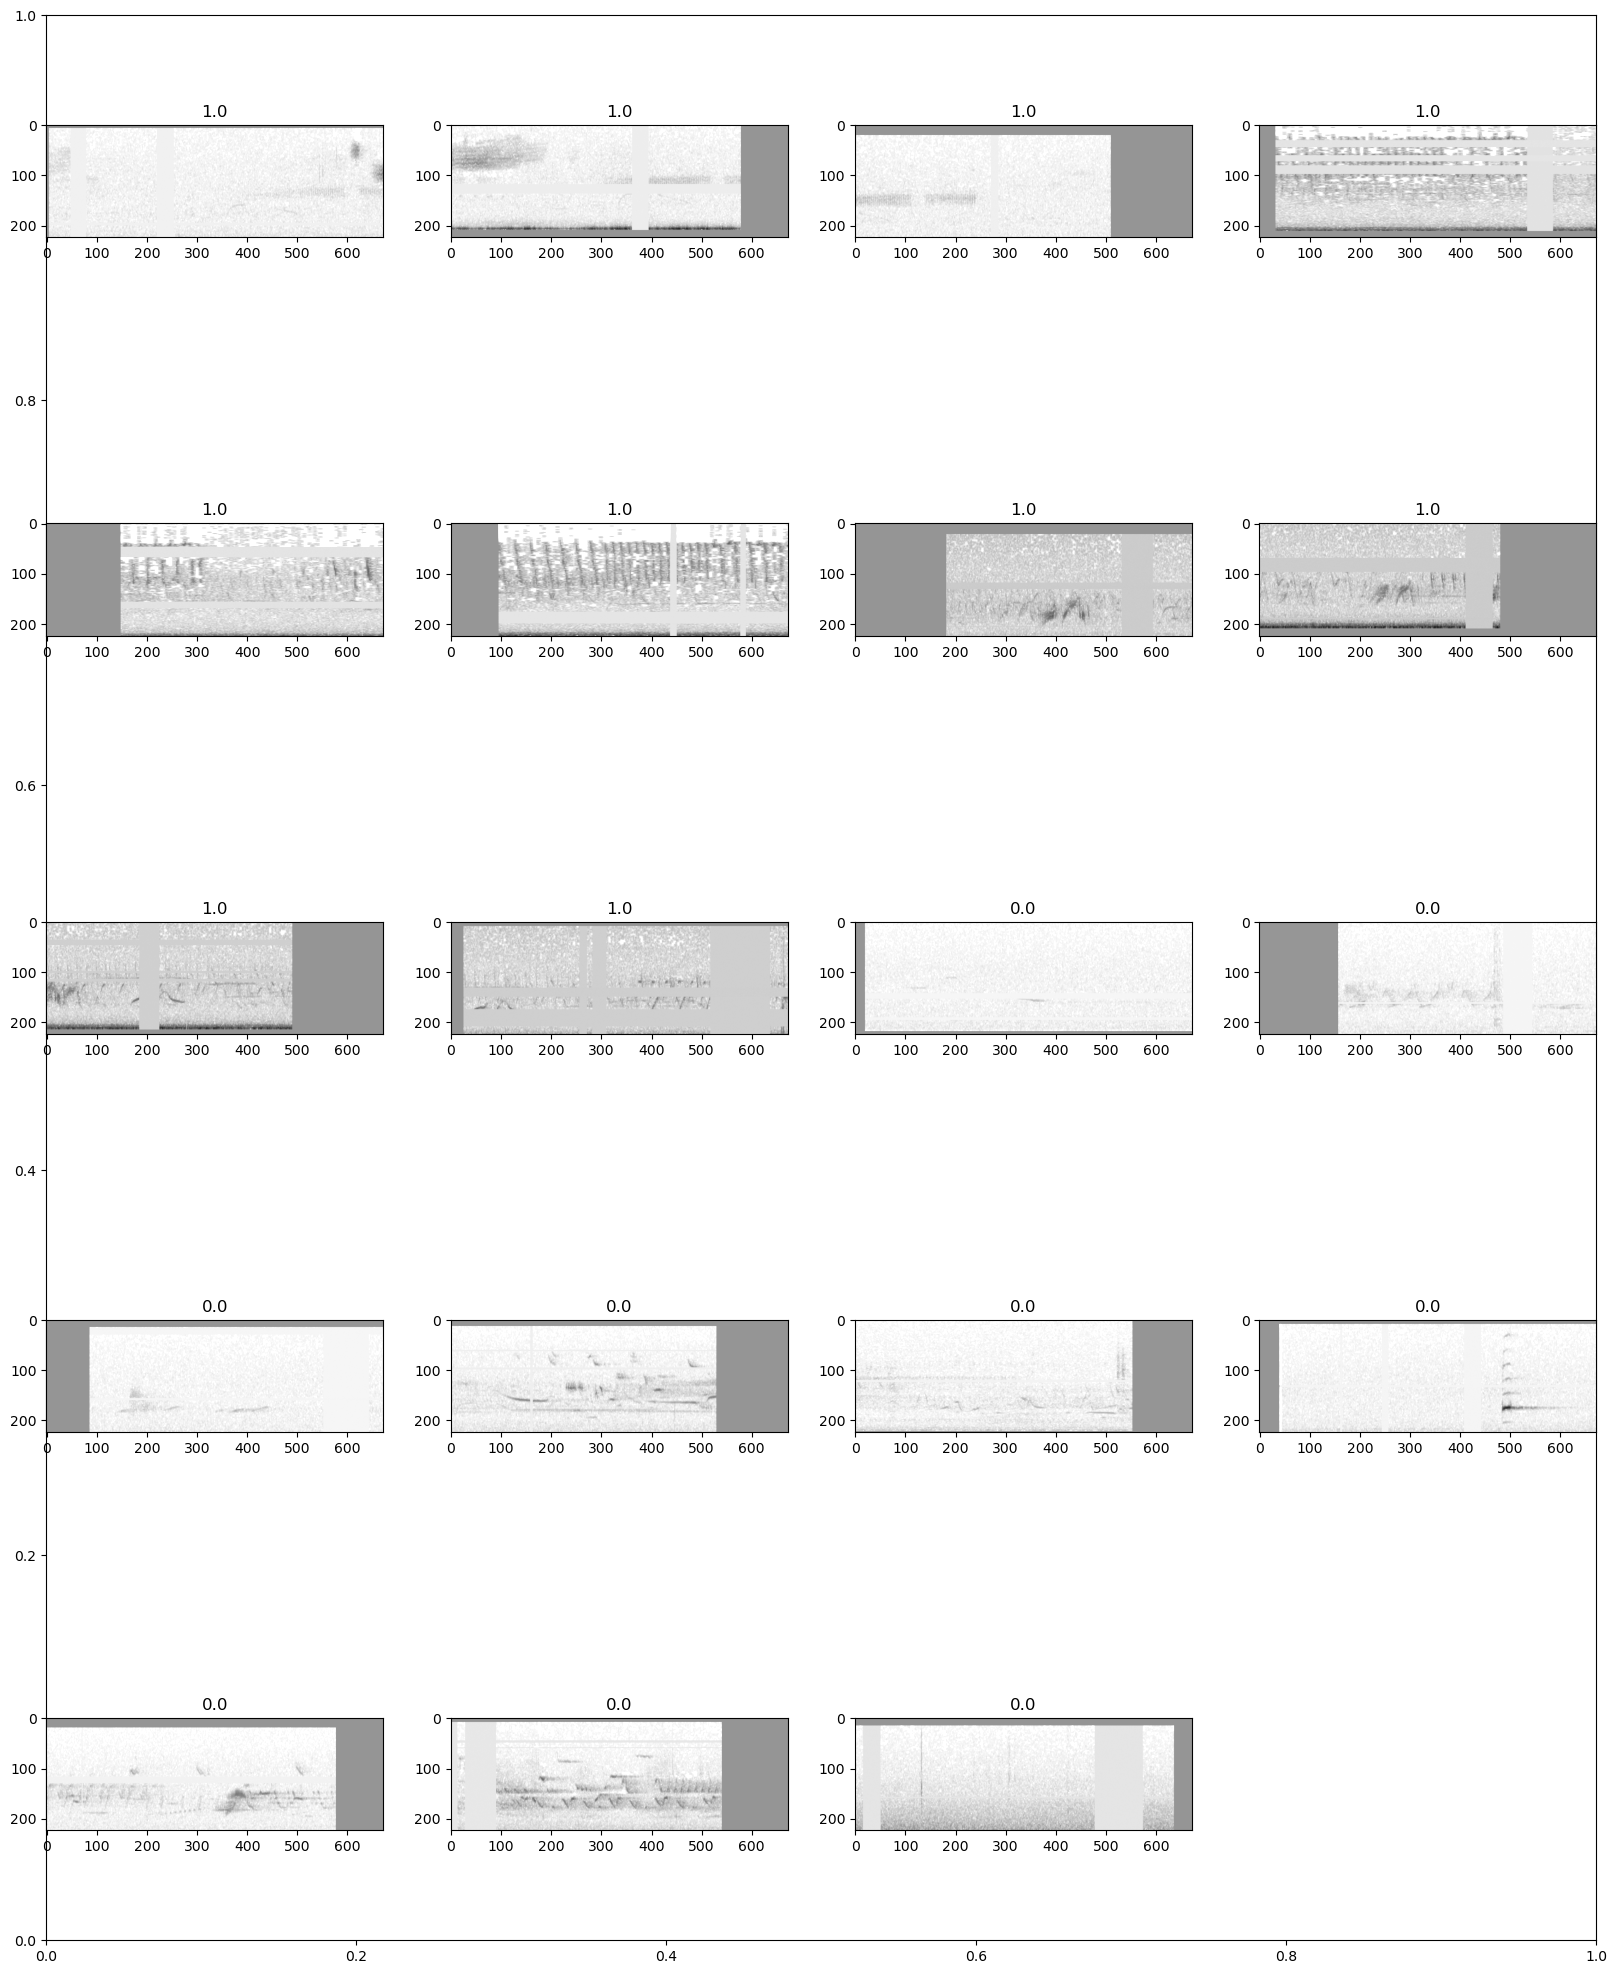

In [34]:
idxs=[i for i in range(10)]+[i for i in range(-9, 0, 1)]
fig = show_tensor_grid([train_dataset[i].data for i in idxs], columns = 4, labels = [train_dataset[i].labels.iloc[0] for i in idxs])

### Can these datasets be interfaced with the fastai dataloaders and training schedules?

Two options to handle greyscale images in a model pretrained on RGB 
1. Change the images: Convert the 1 channel greyscale images to RGB by duplicating the colour dimension 3 times
2. Change the model: Convert the 3 channel model to greyscale by averaging the weights across each channel. 

Both of these approches are explored in this notebook. In practice though, the model will likely be greyscale since there are more and more audio specific models available for transfer learning, so using image recognition models pretrained on colour images won't be as effective. 

In [35]:
from fastai.vision.core import DataLoaders
from fastai.vision.core import DataLoader
# from torch.utils.data._utils.collate import default_collate
# from opensoundscape.ml.utils import collate_audio_samples_to_tensors

In [36]:
from fastai import *
from fastai.vision.all import *

In [37]:
class AudioDatasetWrapper(Datasets):
    '''
    Alternative behaviour to the __getitem__ method of AudioFileDataset.
    Converts greyscale images to RGB
    Returns a tuple of the data and the label.
    '''
    def __init__(self, audio_dataset, greyscale_to_rgb=False):
        self.audio_dataset = audio_dataset
        self.greyscale_to_rgb = greyscale_to_rgb

    def __len__(self):
        return len(self.audio_dataset)

    def __getitem__(self, idx):
        # Extract the data tensor
        # Extract the label as an integer in a tensor
        x = self.audio_dataset[idx].data
        y = torch.tensor(int(self.audio_dataset[idx].labels.iloc[0]))

        if self.greyscale_to_rgb:
            x = x.repeat(3, 1, 1)
        
        return (x, y)

def wrap(dataset):
    return AudioDatasetWrapper(dataset)


In [38]:
# Check channel conversion
print(AudioDatasetWrapper(train_dataset, greyscale_to_rgb=False)[0][0].shape)
print(AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True )[0][0].shape)

torch.Size([1, 224, 672])
torch.Size([3, 224, 672])


The \__getitem__ function of AudioDatasetWrapper returns the label for target presence as an integer `tensor(int)`, so the size of the label tensor is batch size * 1. Later on we can inclue the absence class, or additional classes for noise as one hot encoded values in the labels too. This will need different approach to calcualting loss and metrics. 

In [39]:
AudioDatasetWrapper(train_dataset)[0]

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.7192, -0.7022, -0.7169,  ...,  0.0000,  0.0000,  0.0000],
          [-0.6579, -0.6370, -0.7229,  ...,  0.0000,  0.0000,  0.0000],
          [-0.6116, -0.6462, -0.6948,  ...,  0.0000,  0.0000,  0.0000]]]),
 tensor(1))

In [40]:
# make dataloaders
wrapped_train_ds = AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True)
wrapped_valid_ds = AudioDatasetWrapper(valid_dataset, greyscale_to_rgb=True)
train_dl = DataLoader(wrapped_train_ds,shuffle=True, bs=16)
valid_dl = DataLoader(wrapped_valid_ds, bs=16)
dls = DataLoaders(train_dl, valid_dl, device="mps")
dls.one_batch()[1].shape # label shape

torch.Size([16])

The wrapper only extracts the presence class from the dataset, since at this stage the absence class is redundant. So the presence/absence is encoded as 1 or 0, and isn't one-hot encoded. 

In [41]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([426., 426.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([124., 124.])))

# Out of the box
 the resnet 18 model has 1000 output classes. This is the original number of output classes of the ImageNet dataset it was trained on. We need to explicilty remove the last layer and replace it with a layer with 2 output classes. The activations at index 0 and 1 are all positive, and the rest are small. The head needs replacing with a new head with 2 classes.


### Cross Entropy Loss function
The cross entropy loss function uses softmax to force activations to lie between 0 and 1 and sum to 1, and then takes the negative log of the activation at the index at the correct class. In this way, activations corresponding to the correct class are driven closer to 1, and activations corresponding to the incorrect class are driven closer to 0. 

This explains the reduction of loss during model training - the activations belonging to the class which is never present are made smaller, and the activations belonging to the class which is always present are made larger. 

#### Check the accuracy calculation
The accuracy function finds the index of the maximum value in the input tensor, and compares this with the integer label, for each sample in the batch, then takes the mean of these. It is a bumpy function, whose gradient is 0 everywhere except at the transition points, where its gradient is infinite. This is why accuracy isn't used as a loss function.


In [42]:
# accuracy example
inp_test = tensor([1,2,3,4,5], [2,1,1,1,1]).T
y_test = tensor([1,1,1,1,1])
inp_test, y_test, accuracy(inp_test, y_test)

(tensor([[1, 2],
         [2, 1],
         [3, 1],
         [4, 1],
         [5, 1]]),
 tensor([1, 1, 1, 1, 1]),
 TensorBase(0.2000))

# Model 1 - custom wrapper

# Replace with 2 class head

In [43]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2, device='mps') # replace the head
learner = Learner(dls, model, metrics=accuracy, loss_func=nn.CrossEntropyLoss())
learner.fine_tune(6, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.693210,0.696683,0.500000,01:50


/Users/mikeg/miniforge3/envs/osfltens/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfltens/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


epoch,train_loss,valid_loss,accuracy,time


/Users/mikeg/miniforge3/envs/osfltens/lib/python3.10/site-packages/fastai/learner.py:448: DeprecationWarning: invalid escape sequence '\R'
  e.args = [f"Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:\n\t{e.args[0]}"]


KeyboardInterrupt: 

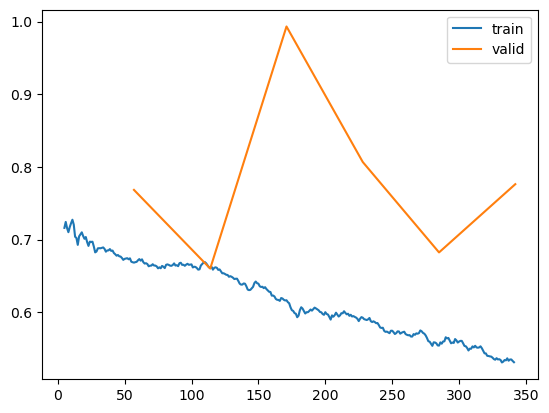

In [ ]:
learner.recorder.plot_loss()

In [ ]:
learner.fine_tune(6, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.581710,0.607000,0.669643,01:21


epoch,train_loss,valid_loss,accuracy,time
0,0.509208,0.692081,0.687500,01:21
1,0.520490,0.705196,0.674107,01:21
2,0.503006,0.537587,0.718750,01:21
3,0.477253,0.567301,0.736607,01:22
4,0.425525,0.618232,0.727679,01:22
5,0.403052,0.588695,0.732143,01:21


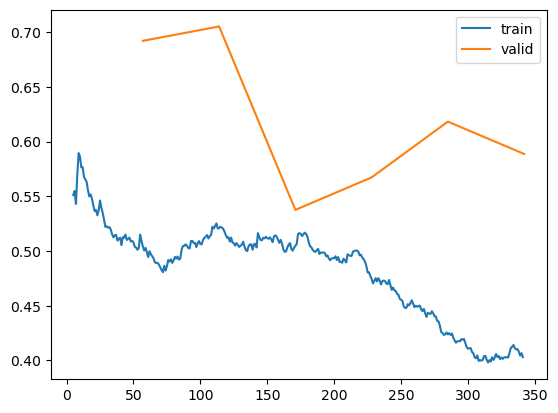

In [ ]:
learner.recorder.plot_loss()

### Training is slow using this approach. 

It could be that the process of converting a clip to a spectrogram is just slow, in which case a speedup is possible by precomputing spectrograms. This was tested at the start of the project and it did result in a fast training cycle.

Also there is AudioDatasetWrapper or other code containing python inefficiencies which should be replaced with tensor operations. OpenSoundScape provides its own collate function for getting tuple of tensors from an AudioFileDataset.
 

#  Try using the opensoundscape custom collate function

This might be quicker due to the use of tensor operations rather than python loops.

`collate_audio_samples_to_tensors` takes a list of AudioSamples and batches them into tensors. This is the behaviour we need to be able to pass the dataset to a fastai learner.

In [28]:
collate_test = opso.ml.utils.collate_audio_samples_to_tensors([train_dataset[i] for i in range(5)])

collate_test[0].shape, collate_test[1].shape

(torch.Size([5, 1, 224, 672]), torch.Size([5, 2]))

In [29]:
collate_test[1]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

#### Difference in target dimension

The leading dimension is the batch dimension. The 2 dimensional target highlights that the data is structured with two target classes: 'present' and 'absent'. Since we're currently only using these two classes, the data could be represented with only one of these classes since the presence of one always indicates the absence of the other. 


### Multi class
providing multiple labels for the classifier to differentiate between could help with performance - a class for 'other bird' 'target bird', 'background' are all derivable from this dataset. 

#### Loss function
The loss function needs to be designed to have smooth gradients as the parameters are changed. Accuracy as measured by the number of correct IDs is suitable for use as a human readable metric, but can't serve as a loss function due to the sudden jumps in integer numbers of correct ids. 

The loss function needs to show that a prediction was slightly better or worse for a small change in parameters. In addition it may need to have a weighting to account for the upsampling or undersampling of classes within the training dataset. 


Different loss functions also require different shaped targets, some need the scores from each target to sum to 1 (Cross Entropy Loss), and some (Binary Cross Entropy) can work on one hot encoded targets and handle multiple positive labels per example. 

In [30]:
# Possible choices for the loss function. 
# nn.CrossEntropyLoss
# nn.BCELoss
# nn.BCEWithLogitsLoss
# opso class aware loss

In [31]:
train_dataset.class_counts()

(Index(['target_presence', 'target_absence'], dtype='object'),
 array([454., 454.]))

In [32]:
train_dataset.label_df.sample(5)

,,,target_presence,target_absence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-482099.flac,79.5,82.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-294414.mp3,6.0,9.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-553777.flac,27.0,30.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-294737.mp3,31.5,34.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-100168.flac,55.5,58.5,0.0,1.0


In [33]:
# def collate_audio_samples_to_float_tensor(batch):
#     tensors = torch.stack([i.data for i in batch])
#     labels = torch.tensor([i.labels.tolist() for i in batch])
#     return tensors, labels


In [34]:
train_dataloader = DataLoader(
    train_dataset,
    bs=16,
    shuffle=True,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)
valid_dataloader = DataLoader(
    valid_dataset,
    bs=16,
    shuffle=False,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)


In [35]:
type(valid_dataloader.one_batch())

tuple

Passing `create_batch = opso.ml.utils.collate_audio_samples_to_tensors` into `DataLoader` gives the expected behaviour of returning a tuple containing tensor spectrograms and their labels.

In [36]:
dls = DataLoaders(train_dataloader,valid_dataloader, device="mps")

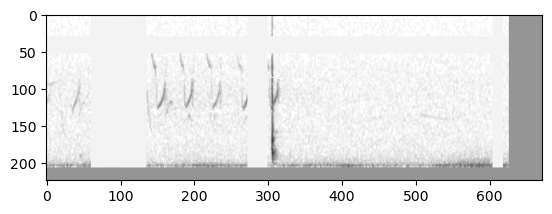

In [37]:
# training set spectrograms have augmentations:
show_tensor(dls.train.one_batch()[0].cpu()[0])

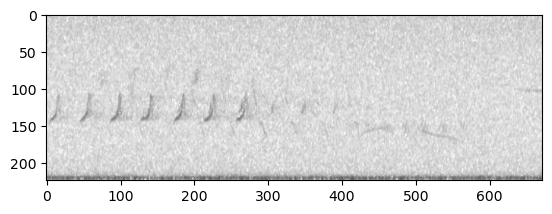

In [38]:
# no augmentations on the validation set:
show_tensor(dls.valid.one_batch()[0].cpu()[0])

### Check shape of input labels

In [39]:
x, y = dls.one_batch()
x.shape, y.shape
x.device, y.device, x.dtype, y.dtype

(device(type='mps', index=0),
 device(type='mps', index=0),
 torch.float32,
 torch.float32)

# Model 2: average model channel weights
### With BCEWithLogitsLoss

### Try importing the model from timm
The timm library should handle this channel mismatch by adding the weights from each of the channels into one greyscale channel. Another approach is to duplicate the channels in the greyscale image to create a 3 channel image by using torch.stack or tensor.repeat.

custom model https://forums.fast.ai/t/fastai-v2-pretrained-unet-with-different-number-of-channels/85776

In [40]:
model = timm.create_model('resnet18',pretrained=True, in_chans=1, num_classes=2)

Choose a suitable loss function for the input and target shapes.

In [41]:
multi_metrics = [accuracy_multi, RecallMulti(), PrecisionMulti(), F1ScoreMulti()]

In [52]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=multi_metrics)

In [53]:
learn.fine_tune(4, 1e-4)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,time
0,0.690316,0.689825,0.546875,0.750000,0.544386,0.612143,00:59


epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,time
0,0.691149,0.688912,0.546875,0.745536,0.546029,0.615542,00:59
1,0.689972,0.690304,0.542411,0.714286,0.547776,0.590637,00:59
2,0.688304,0.690199,0.529018,0.691964,0.532415,0.589797,00:58
3,0.688540,0.690313,0.513393,0.709821,0.516131,0.592550,00:59


In [44]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([454., 454.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([112., 112.])))

Training takes 4m17s for a sample of 608 training samples and 130 validation samples. 

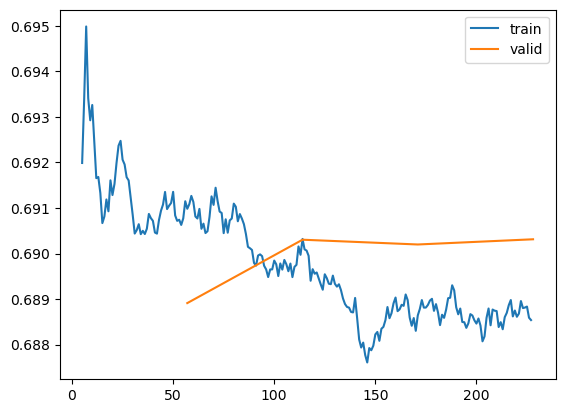

In [54]:
learn.recorder.plot_loss()

In [46]:
xb, yb = dls.one_batch()
xb.shape, yb.shape
model(xb).shape, yb.shape

(torch.Size([16, 2]), torch.Size([16, 2]))

### With CrossEntropyLoss

In [55]:
model = timm.create_model('resnet18',pretrained=True, in_chans=1, num_classes=2)
learn = Learner(dls, model, metrics=multi_metrics, loss_func=nn.CrossEntropyLoss())
learn.fine_tune(4, 1e-4)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,time
0,0.696484,0.693207,0.500000,0.102679,0.401316,0.156667,00:58


epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,time
0,0.688205,0.698936,0.486607,0.200893,0.436264,0.228917,00:58
1,0.690452,0.699255,0.497768,0.227679,0.416667,0.244545,00:59
2,0.688602,0.701251,0.493304,0.236607,0.445192,0.253205,00:59
3,0.688144,0.701819,0.500000,0.227679,0.252475,0.239437,00:59


Some runs have the accuracy stuck at 0.50000000 during every calculaton. 

In [48]:
xb, yb = dls.one_batch()
xb.shape, model(xb).shape

(torch.Size([16, 1, 224, 672]), torch.Size([16, 2]))

In [49]:
learn.summary()

ResNet (Input shape: 16 x 1 x 224 x 672)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 336 
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 56 x 168  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                          

### Check what order the preprocessing happens in opso


In [50]:
train_dataset.preprocessor.pipeline

load_audio                              Action calling <bound method Audio.from_file of <class 'opensoundscape.audio.Audio'>>
random_trim_audio                                            Augmentation Action calling <function trim_audio at 0x165178ee0>
trim_audio                                                                Action calling <function trim_audio at 0x165178ee0>
to_spec              Action calling <bound method Spectrogram.from_audio of <class 'opensoundscape.spectrogram.Spectrogram'>>
bandpass                                                        Action calling <function Spectrogram.bandpass at 0x151f8e3b0>
to_tensor                                                                                                              Action
time_mask                                                     Augmentation Action calling <function time_mask at 0x165179fc0>
frequency_mask                                           Augmentation Action calling <function frequency_mask at 0x165

If we preprocess the spectrograms and save them to disk, we lose the flexibility to easily switch between different spectrogram parameter settings. Mixup would be affected too, since this should be applied at the audio level. The rest of the hyperparameters would be applicable to a preprocessed spectrogram. 


In [51]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

# Conclusion

The model is training and the loss is decreasing on the validation and test sets, and the accuracy is increasing in step with reduction in loss. Sometimes the accuracy doesn't increase in step with the loss, or at all, and sometimes the loss doesn't decrease as much from one run to the next, and this seems to be tied to the sample of the training set taken at the start rather than the initialization of the model. 

Further work will be to improve the quality of the dataset as much as possible:

- increase the number of positive examples
- create a buffer area next to the positive example so that any segments of audio which contan a part of the target species call are not in the training set. 
- Change the spectrogram parameters so that the spectrograms contain clearer images. 